In [1]:
import os
import subprocess

import numpy as np
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torchvision.transforms import ToTensor, Compose, CenterCrop, Resize, Normalize
import matplotlib.pyplot as plt
from torchvision.models.resnet import resnet101
from torch.utils.data import DataLoader
from torch.optim import Adam

from nuy_v2_loader import NYUV2Dataset
from stepper import Stepper
from summary_writer import SummaryWriter, WandBSummaryWritter
from metrics import (
  absolute_relative_mean_error,
  root_mean_squared_error,
  average_absolute_log_error,
  threshold_acc
)
from loss import sil_loss
from models.resnet101_pyramid import Resnet101Pyramid
from models.res_refinet import Resnet101RefineNet

In [2]:
# CONSTANTS
SEED = 43
EPSILON = 1e-7
BATCH_SIZE = 16
MAX_DATA_LENGHT = 2000

MEAN = (0.4644, 0.3905, 0.3726) # Derived with utils.py
STD = (0.2412, 0.2432, 0.2532) # Derived with utils.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
np.random.seed(SEED)

In [4]:
# if not os.path.exists('datasets/diode.tar.gz'):
#     subprocess.run(
#         ['curl', '-L', '-o', 'datasets/diode.tar.gz', 'http://diode-dataset.s3.amazonaws.com/train.tar.gz'],
#         check=True
#     )

In [6]:
NYU_V2_IMG_DIMENSION = (448, 608)

transforms = Compose([
  ToTensor(), CenterCrop(NYU_V2_IMG_DIMENSION), Resize(size=(224, 320)),
])
rgb_t = Compose([
  transforms, Normalize(mean=MEAN, std=STD)
])
train_dataset = NYUV2Dataset("ds", rgb_t, transforms, 'train', download=True, max_lenght=MAX_DATA_LENGHT)
test_dataset = NYUV2Dataset("ds", rgb_t, transforms, 'test', download=True, max_lenght=MAX_DATA_LENGHT)

Failed to load tar file
Finished loading dataset
Failed to load tar file
Finished loading dataset


/opt/saturncloud/envs/saturn/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imsh

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


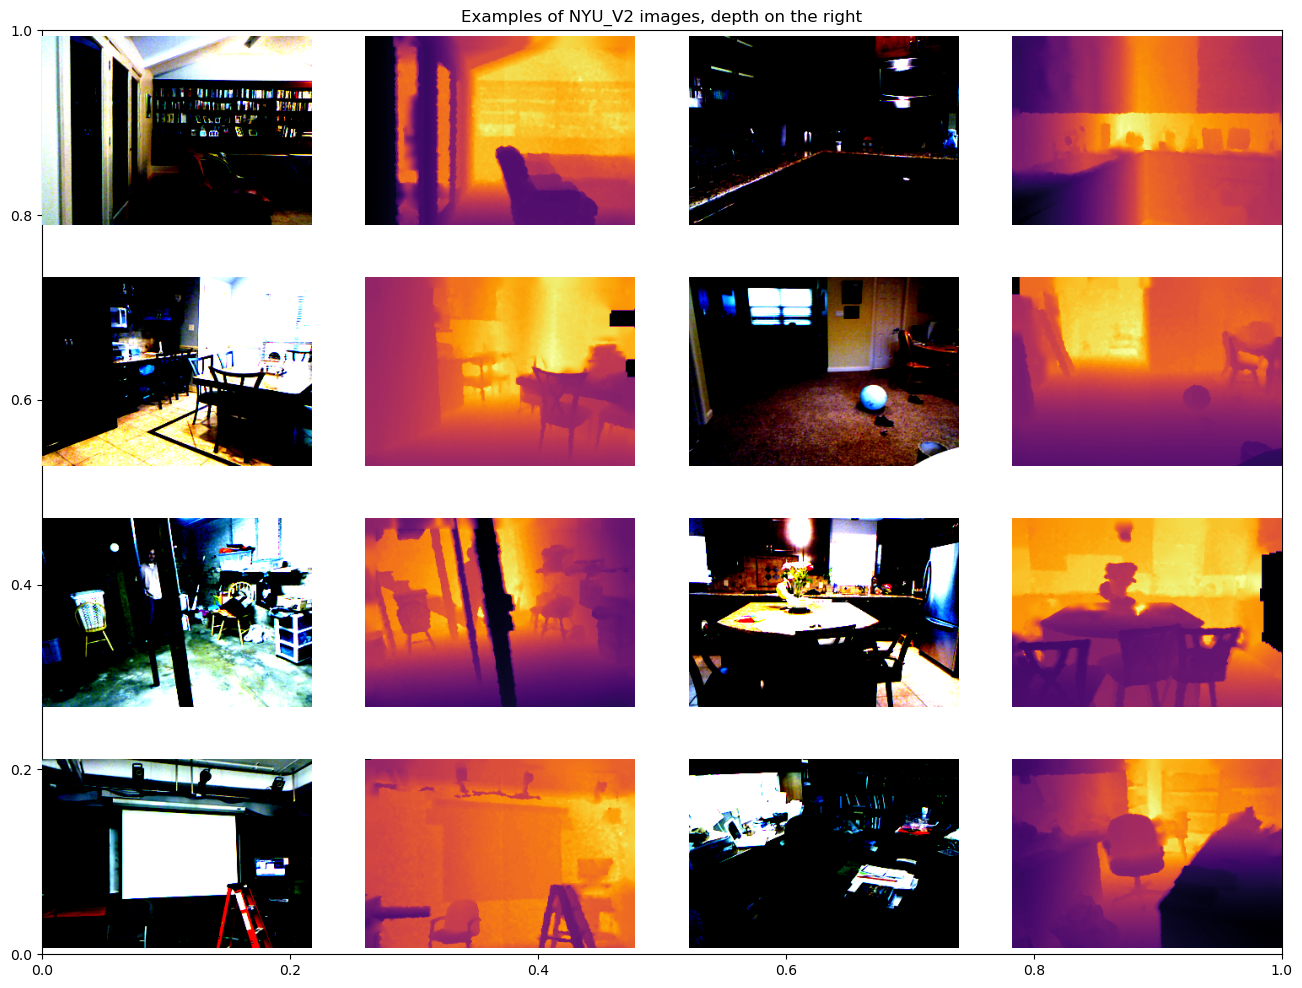

In [7]:
random_pick = np.random.randint(0, 45000, 8)

plt.figure(figsize=(16, 12))
plt.title("Examples of NYU_V2 images, depth on the right")
for i, img in enumerate(random_pick):
  ax = plt.subplot(4, 4, i * 2 +1)
  rgb, depth = train_dataset[img]
  ax.imshow(rgb.permute((1, 2, 0)))
  ax.set_axis_off()
  
  ax = plt.subplot(4, 4, i * 2 + 2)
  ax.imshow(depth[0], cmap='inferno')
  ax.set_axis_off()

# As we can see data isn't perfect, sensor weren't able to capture highly illuminated objects, mirrors and etc

## Baseline

In [8]:
summary_writer = WandBSummaryWritter()

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
resnet101_refinet = Resnet101RefineNet()
optim = Adam(resnet101_refinet.parameters(), lr=1e-4)
stepper = Stepper(resnet101_refinet, optim=optim, loss_fn=sil_loss, summary_writter=summary_writer)
stepper.set_loaders(train_loader, val_loader)
stepper.to(device)

summary_writer.register(
  project='pure_depth',
  config={
    'architecture': 'Resnet101_Refinet',
    'optim': 'Adam',
    'device': device,
    'batch_size': BATCH_SIZE,
    'loss_fn': sil_loss.__doc__
  }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: percalee. Use `wandb login --relogin` to force relogin


In [9]:
torch.autograd.set_detect_anomaly(True)
stepper.train(n_epochs=10)
stepper.save_checkpoint(file_name='resnet101_dummy')

train step:   0%|          | 0/125 [00:00<?, ?batch/s]/opt/saturncloud/envs/saturn/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
validation step: 100%|██████████| 41/41 [00:17<00:00,  2.28batch/s, loss=0.171]


/opt/saturncloud/envs/saturn/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


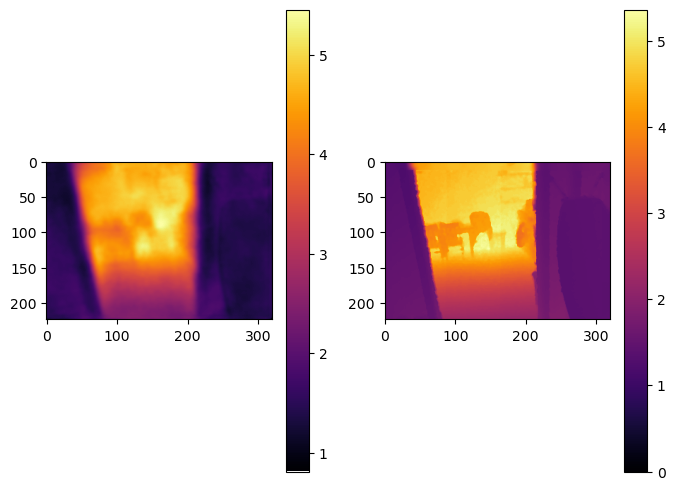

In [23]:
# Just sanity check
x, y = train_dataset[200]
pred = stepper.model(x.unsqueeze(0).to(device))

vmax = y.max()
plt.figure(figsize=(8, 6))
ax0 = plt.subplot(1, 2, 1)
show = ax0.imshow(
  np.transpose(pred[0].detach().cpu().numpy(), (1, 2, 0)),
  cmap='inferno'
)
plt.colorbar(show, ax=ax0)
ax1 = plt.subplot(1, 2, 2)
show = ax1.imshow(
  np.transpose(y.detach().numpy(), (1, 2, 0)), 
  cmap='inferno', 
  vmin=0
)
plt.colorbar(show, ax=ax1)

In [24]:
def evaluate_metrics(model: nn.Module, data_loader: DataLoader, summary_writer: SummaryWriter):
  running_metrics: np.array = None
  
  model.eval()
  with torch.no_grad():
    for x_batch, y_batch in data_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        pred = model(x_batch)

        metrics = np.array((
          absolute_relative_mean_error(pred, y_batch).item(),
          root_mean_squared_error(pred, y_batch).item(),
          average_absolute_log_error(pred, y_batch).item(),
          *(
            metric.item() 
            for metric 
            in threshold_acc(pred, y_batch)
          )
        )).reshape(1, -1)
        
        if running_metrics is None:
          running_metrics = metrics
        else:
          running_metrics = np.vstack((running_metrics, metrics))
  
  mean_metrics = np.mean(running_metrics, axis=0)
  summary_writer.track_object({
    'evaluation_metrics': {
      'absolute_relative_mean_error': mean_metrics[0],
      'root_mean_squared_error': mean_metrics[1],
      'average_absolute_log_error': mean_metrics[2],
      'threshold_accuracy_delta_1': mean_metrics[3],
      'threshold_accuracy_delta_2': mean_metrics[4],
      'threshold_accuracy_delta_3': mean_metrics[5]
    }
  })

evaluate_metrics(stepper.model, val_loader, summary_writer)

In [25]:
summary_writer.finalize()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▂▂▂▁▁▁▁▁▁
val_loss,▄▇█▅▁▂▆▄▄▄
epoch,9
train_loss,0.01208
val_loss,0.18414


In [ ]:
def foreach(iterable, call):
  for i in iterable:
    call(i)
    
def assertIsNone(obj):
  assert obj is None

def assertIsNotNone(obj):
  assert obj is not None
    
base = Resnet101Pyramid()
base.to(device)
x, y = train_dataset[0]

pred = base(x.unsqueeze(0).to(device))
loss = sil_loss(pred, y.unsqueeze(0).to(device))

foreach(base.layer3.parameters(), lambda p: assertIsNone(p.grad))
foreach(base.smooth1.parameters(), lambda p: assertIsNone(p.grad))
foreach(base.predictor0.parameters(), lambda p: assertIsNone(p.grad))

loss.backward()

foreach(base.layer3.parameters(), lambda p: assertIsNone(p.grad))

foreach(base.dec0.parameters(), lambda p: assertIsNotNone(p.grad))
foreach(base.dec1.parameters(), lambda p: assertIsNotNone(p.grad))
foreach(base.dec2.parameters(), lambda p: assertIsNotNone(p.grad))
foreach(base.dec3.parameters(), lambda p: assertIsNotNone(p.grad))
foreach(base.smooth1.parameters(), lambda p: assertIsNotNone(p.grad))
foreach(base.smooth2.parameters(), lambda p: assertIsNotNone(p.grad))
foreach(base.smooth3.parameters(), lambda p: assertIsNotNone(p.grad))
foreach(base.predictor0.parameters(), lambda p: assertIsNotNone(p.grad))
foreach(base.predictor1.parameters(), lambda p: assertIsNotNone(p.grad))

for p in base.dec2.parameters():
  print(p.grad)
# base.predictor0.state_dict()

tensor([[[[ 0.6502]],

         [[ 0.0491]],

         [[ 0.0325]],

         ...,

         [[ 1.0744]],

         [[ 0.0956]],

         [[ 0.1206]]],


        [[[-1.4055]],

         [[-0.1451]],

         [[-0.2961]],

         ...,

         [[-3.0456]],

         [[-0.4967]],

         [[-0.3732]]],


        [[[-0.5961]],

         [[-0.1130]],

         [[-0.1831]],

         ...,

         [[-1.8954]],

         [[-0.2827]],

         [[-0.1811]]],


        ...,


        [[[ 0.4650]],

         [[ 0.1740]],

         [[ 0.0502]],

         ...,

         [[ 0.8212]],

         [[ 0.0501]],

         [[ 0.0404]]],


        [[[-0.6767]],

         [[-0.1048]],

         [[-0.1590]],

         ...,

         [[-1.6846]],

         [[-0.1999]],

         [[-0.1807]]],


        [[[ 0.1759]],

         [[ 0.0318]],

         [[ 0.0200]],

         ...,

         [[ 0.6619]],

         [[ 0.1257]],

         [[ 0.0784]]]], device='cuda:0')
